In [1]:
import numpy as np
import pandas as pd

In [2]:
import tensorflow as tf

In [3]:
import threading
import os
import cPickle as pickle
import logging
import pprint
import glob
import collections
import struct
import json
logging.basicConfig(format='%(asctime)s %(levelname)s: %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p', level=logging.INFO)


In [4]:
logging.info('abc')

08/16/2017 06:55:41 PM INFO: abc


In [5]:
class GeneratorRunner(object):
    "Custom runner that that runs an generator in a thread and enqueues the outputs."

    def __init__(self, generator, placeholders, enqueue_op, close_op):
        self._generator = generator
        self._placeholders = placeholders
        self._enqueue_op = enqueue_op
        self._close_op = close_op

    def _run(self, sess, coord):
        try:
            while not coord.should_stop():
                try:
                    values = next(self._generator)

                    assert len(values) == len(self._placeholders), \
                        'generator values and placeholders must have the same length'

                    feed_dict = {placeholder: value \
                        for placeholder, value in zip(self._placeholders, values)}
                    sess.run(self._enqueue_op, feed_dict=feed_dict)
                except (StopIteration, tf.errors.OutOfRangeError, tf.errors.DeadlineExceededError, tf.errors.CancelledError) as e:
                    logging.warning ("%s %s %s", self.__class__.__name__, "exception:", str(type(e)))
                    try:
                        sess.run(self._close_op)
                    except Exception:
                        pass
                    return
        except Exception as ex:
            if coord:
                logging.info ("%s %s %s %s", self.__class__.__name__, "request stop from", self._run.__name__, str(ex))
                coord.request_stop(ex)
                pass
            else: 
                raise

    def create_threads(self, sess, coord=None, daemon=False, start=False):
        "Called by `start_queue_runners`."

        thread = threading.Thread(
            target=self._run,
            args=(sess, coord))

        if coord:
            coord.register_thread(thread)

        if daemon:
            thread.daemon = True

        if start:
            thread.start()

        return [thread]

def read_batch_generator(
        generator, dtypes, shapes, batch_size,
        queue_capacity=10000,
        allow_smaller_final_batch=False):
    "Reads values from an generator, queues, and batches."

    assert len(dtypes) == len(shapes), 'dtypes and shapes must have the same length'
    logging.info('shapes: %s, types: %s, batchsize: %d', str(shapes), str(dtypes), batch_size)
    queue = tf.FIFOQueue(
        capacity=queue_capacity,
        dtypes=dtypes,
        shapes=shapes)

    placeholders = [tf.placeholder(dtype, shape) for dtype, shape in zip(dtypes, shapes)]

    enqueue_op = queue.enqueue(placeholders)
    close_op = queue.close(cancel_pending_enqueues=True)
    global_close_ops.append(close_op)
    queue_runner = GeneratorRunner(generator, placeholders, enqueue_op, close_op)
    tf.train.add_queue_runner(queue_runner)

    if allow_smaller_final_batch:
        return queue.dequeue_up_to(batch_size)
    else:
        return queue.dequeue_many(batch_size)    

In [6]:
LEN1=64*2
import Queue,random
class MemoryGenerator(object):
    def __init__(self, daily_data,attrib_data, epochs=np.inf):
        self.daily_data = daily_data
        self.attrib_data = attrib_data        
        self.shuffle=True
        self.epochs = epochs
        self.N = len(self.daily_data)*10
        self.curr_epoch = 1
        self.curr_i = 0
        self.q = Queue.Queue()
        if self.shuffle:
            self.do_shuffle()
    def __iter__(self):
        return self
    def do_shuffle(self):
        idx = np.random.permutation(range(len(self.daily_data)))
        self.daily_data = self.daily_data[idx]     
        self.attrib_data = self.attrib_data[idx]
    def fill_queue(self):
        for _ in range(100):
            i=int(np.random.random()*len(self.daily_data))
            attrib_row=self.attrib_data[i]
            row=self.daily_data[i]
            len1=LEN1
            len2=60
            j= random.randint(len1,len(row)-1)
            x=row[j-len1:j]
            part_y=row[j:j+len2]
            y=np.zeros(len2,dtype=np.float32)
            y[:len(part_y)]=part_y
            mask=np.zeros(len2,dtype=np.float32)
            mask[:len(part_y)]= (part_y!=0)*1
            self.q.put((x.astype(np.float32),attrib_row.astype(np.float32),np.array(y,dtype=np.float32),mask))
    def __next__(self):
        return self.next()
    def next(self):
        if self.curr_i >= self.N:
            self.curr_i = 0
            self.curr_epoch += 1
            if self.curr_epoch > self.epochs: raise StopIteration
            if self.shuffle: 
                self.do_shuffle()
        if self.q.empty(): self.fill_queue()
        X1,X2, y,mask = self.q.get()
        self.curr_i += 1
        return X1,X2, y,mask 


In [7]:
def make_train_readers(daily_data,attrib_data, nrows=None, batchsize=60):
    print daily_data.shape, attrib_data.shape
    train_generator = MemoryGenerator(daily_data,attrib_data)
    return read_batch_generator(train_generator, [tf.float32, tf.float32, tf.float32, tf.float32], 
                                [(LEN1,), (12,), (60,),(60,)], batchsize, allow_smaller_final_batch=True),train_generator

In [8]:
locales=sorted([u'en', u'ja', u'de', u'fr', u'zh', u'ru', u'es'])
locale_map={v:u for u,v in enumerate(locales)}
locale_map

{u'de': 0, u'en': 1, u'es': 2, u'fr': 3, u'ja': 4, u'ru': 5, u'zh': 6}

In [9]:
access_map={u'all-access':0, u'mobile-web':1, u'desktop':2}
agent_map={u'all-agents':0, u'spider':1}
access_map,agent_map

({u'all-access': 0, u'desktop': 2, u'mobile-web': 1},
 {u'all-agents': 0, u'spider': 1})

In [10]:
def f_map(series, data_map):
    lst=[]
    keys=list(data_map.keys())
    for k in keys:
        lst.append(series.map(lambda u: (u==k)*1))
    df=pd.concat(lst,axis=1)
    df.columns=[series.name+"_"+u for u in keys]
    return df

In [11]:
def make_data():
    import pandas as pd
    csv_path="../input/newtrain_1.csv"
    data = pd.read_csv(csv_path, nrows=None)
    datecols=[u for u in data.columns if u.startswith("20")]
    daily_data=data[datecols].values.astype(np.float32)
    attrib_data=pd.concat([f_map(data.locale,locale_map),
                           f_map(data.agent,agent_map),
                           f_map(data.access,access_map)],axis=1).values.astype(np.float32)    
    print daily_data.shape,attrib_data.shape
    return daily_data,attrib_data

In [12]:
daily_data,attrib_data=make_data()

(145063, 550) (145063, 12)


In [13]:
print np.mean(daily_data==0)
#daily_data += (daily_data==0)*0.1
#print np.mean(daily_data==0)

0.0909115851232


In [14]:
if 0:
    global_close_ops = []
    #daily_data,attrib_data=make_data()
    _, generator=make_train_readers(daily_data,attrib_data)
    a,b,c,d= generator.next()
    #print a,b,c,d    
    print a.shape,b.shape,c.shape,d.shape


In [15]:
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>" % size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    from IPython.display import clear_output, Image, display, HTML

    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph' + str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))


In [16]:
def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def bias_variable(shape, name):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=name)

def dense(x, size, scope, with_activation=True):
    if 1:
        with tf.variable_scope(scope):
            w = weight_variable(shape=[int(x.get_shape()[-1]), size], name=None)
            b = bias_variable(shape=[size], name=None)
            h1 = tf.matmul(x, w) + b
            layer=tf.sigmoid(h1) if with_activation else h1
            print layer.get_shape()
    return layer,w,b
from tensorflow.contrib import rnn
def lstm(x,x2, n_hiddens, n_input, n_output, scope):
    if 1:
        with tf.variable_scope(scope):
            x = tf.reshape(x, [-1, n_input])
            x = tf.split(x,n_input,1)
            basic_rnn_cells = [rnn.BasicLSTMCell(n_hidden) for n_hidden in n_hiddens]
            rnn_cell = rnn.MultiRNNCell(basic_rnn_cells)
            outputs, states = rnn.static_rnn(rnn_cell, x, dtype=tf.float32) 
            concat_x=tf.concat([outputs[-1],x2],-1)
            print outputs[-1].get_shape(), concat_x.get_shape()             
            return concat_x

def get_Xy(x_size,x2_size,y_size):
    X = tf.placeholder("float", shape=[None, x_size], name='input_x')
    X2 = tf.placeholder("float", shape=[None, x2_size], name='input_x2')    
    l2_scale = tf.placeholder(tf.float32, name='l2_scale')
    y = tf.placeholder("float", shape=[None, y_size], name='input_y')
    mask = tf.placeholder("float", shape=[None, y_size], name='mask')
    return X,X2, y,mask, l2_scale

In [17]:
class MyModel(object):
    def __init__(self, x_size,y_size, n_hiddens,l2_scale,phase=True ):
        self.phase=phase
        n_hiddens=n_hiddens
        self.graph = tf.Graph()
        self.all_denses = []
        with self.graph.as_default(): 
            self.X, self.X2, self.y, self.mask, self.l2_scale = get_Xy(x_size,12, y_size)
            assert(x_size == self.X.get_shape()[1])
            with tf.variable_scope("nodes"):
                self.X, self.y, self.loss, self.smape \
                     = self.make_model(x_size=x_size, y_size=y_size, n_hiddens=n_hiddens)

            
            with tf.variable_scope('saver'):
                    self.saver = tf.train.Saver()

            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            with tf.variable_scope('optimizer'):
                with tf.control_dependencies(update_ops):
                    self.optimizer = tf.train.AdamOptimizer()#.minimize(self.loss)
                    gvs = self.optimizer.compute_gradients(self.loss)
                    capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs]
                    self.train_op = self.optimizer.apply_gradients(capped_gvs)
        self._session = None    
    @property
    def session(self): 
        if self._session is None:
            config = tf.ConfigProto(log_device_placement=True)
            config.gpu_options.per_process_gpu_memory_fraction = 0.5  # don't hog all vRAM
            self._session = tf.Session(graph=self.graph,config=config)
        return self._session
    
    def close_session(self):
        if self._session is not None:
            self._session.close()
            self._session = None
    def initialize(self, session=None):
        with self.graph.as_default():
            init_op = tf.global_variables_initializer()        
        self.session.run(init_op) 
        return self.session
 
        
    def make_model(self, x_size,y_size, n_hiddens):
        X_raw, y  = self.X, self.y 
        logging.debug ("%s %s", self.__class__.__name__,
                       'input shapes: X={},y={}'.format(X_raw.get_shape(), None if y is None else y.get_shape()))

        h = tf.log(X_raw+1)
        #h=     tf.layers.batch_normalization(h,center=False, scale=True,training=self.phase)
        
        h=lstm(h,self.X2, [n_hiddens[0]], x_size, y_size, 'lstm')
        for i in range(0, len(n_hiddens)):
            n_hidden = n_hiddens[i]
            h, w,b = dense(h, n_hidden,'dense')
            self.all_denses.append((h,w,b))

        logits_sum,_,_=dense(h,y_size,'dense',with_activation=False)
        
        with tf.variable_scope("loss"):
            epsilon = 1e-7        
            l2_loss = 0
            if 1:  # self.l2_scale > 0:
                logging.info('use l2 reg scale %s', str(self.l2_scale))
                for _,w,_ in self.all_denses:
                    l2_loss = l2_loss + tf.reduce_sum(w ** 2)
                l2_loss = l2_loss * self.l2_scale
                self.l2_loss = l2_loss
            if 1:
                predictions = tf.identity(logits_sum, name='prediction')
                float_labels = tf.cast(y, tf.float32)
                
                ratio=predictions/(float_labels+1e-4)
                additional_loss= 0.02*tf.cast(ratio>9,tf.float32)*tf.abs(ratio)\
                    +0.02*tf.cast(predictions<0.0,tf.float32)*tf.abs(predictions)
                additional_loss = tf.reduce_sum(additional_loss*self.mask)/tf.reduce_sum(self.mask)
                this_loss =  tf.abs(predictions-float_labels)/(tf.abs(predictions)+tf.abs(float_labels))
                this_loss=this_loss*self.mask
                this_loss = tf.identity(2* tf.reduce_sum(this_loss)/tf.reduce_sum(self.mask), name='smape')                          
                loss = this_loss + l2_loss+additional_loss

            logging.info ('%s %s %s', self.__class__.__name__, 'logits shape', logits_sum.get_shape())

        return X_raw, y, loss, this_loss
 
    
    def save(self, prefix, ckpt=1):
        checkpoint_name = '{}/model_{}'.format(prefix, 0)
        self.saver.save(self.session, checkpoint_name, global_step=ckpt)

    def load(self, prefix, ckpt=1):
        self.saver.restore(self.session, '{}/model_{}-{}'.format(prefix, self.model_id, ckpt))


In [18]:
if 0:
    tf.reset_default_graph()
    model = MyModel(x_size=5, y_size=2, n_hiddens=[2,2], l2_scale=0.1)
    model.initialize()
    #print [n.op for n in model.graph.as_graph_def().node];
    show_graph(model.graph.as_graph_def())

In [19]:
def svd_orthonormal(shape):
    print(shape)
    if len(shape) < 2:
        raise RuntimeError("Only shapes of length 2 or more are supported.")
    flat_shape = (shape[0], np.prod(shape[1:]))
    a = np.random.standard_normal(flat_shape)
    u, _, v = np.linalg.svd(a, full_matrices=False)
    q = u if u.shape == flat_shape else v
    q = q.reshape(shape)
    return q

def get_activations(model, h, X_batch):
    activations = model.session.run(h, feed_dict={model.X:X_batch})
    return activations

def LSUVinit(model, batch):
    # only these layer classes considered for LSUV initialization; add more if needed    
    margin = 0.1
    max_iter = 10
    layers_inintialized = 0
    for h,w,_ in model.all_denses:
        # avoid small layers where activation variance close to zero, esp. for small batches
        if np.prod(h.get_shape()) < 32:
            print(h, 'too small')
            continue
        logging.info('LSUV initializing' + str(h))
        layers_inintialized += 1
        needed_variance = 1.0
        
        # print ('pre',np.sum(model.session.run(np.abs(w))))
        weights = svd_orthonormal(w.get_shape())
        model.session.run(tf.assign(w, weights))
        # print (model.session.run(w),weights)
        # print ('post',np.sum(model.session.run(np.abs(w))),np.sum(np.abs(weights)))        
        acts1 = get_activations(model, h, batch)
        # print (acts1,needed_variance)
        
        var1 = np.var(acts1)
        iter1 = 0
        logging.info('var1 %f', var1)
        while (abs(needed_variance - var1) > margin):
            if np.abs(np.sqrt(var1)) < 1e-7: break  # avoid zero division
            weights /= np.sqrt(var1) / np.sqrt(needed_variance)
            model.session.run(tf.assign(w, weights))
            acts1 = get_activations(model, h, batch)
            var1 = np.var(acts1)
            iter1 += 1
            # print (acts1)
            logging.info('var1 %f', var1)
            if iter1 > max_iter:
                break
    logging.info('LSUV: total layers initialized %d', layers_inintialized)   
    return model


In [20]:

class BN(object):
    def __init__(self, x_size, y_size, n_hiddens, l2_scale=0.0, prefix='./tmp'):
        self.x_size = x_size
        self.y_size=y_size
        self.n_hiddens = n_hiddens
        self.l2_scale = l2_scale
        self.prefix = prefix
    

    def train_one_epoch(self, n_epoch, sess, model, train_reader,test_reader, coord):
        count = 0
        loss = []; l2_loss = []
        while not coord.should_stop():
            try:
                if  True:
                    X,X2, y,mask = sess.run(train_reader)
                    feed_dict = {model.X:X, model.X2:X2, model.y:y, model.mask:mask, model.l2_scale: self.l2_scale}
                    _, a, aa = model.session.run([model.train_op, model.loss, model.smape], 
                                                    feed_dict=feed_dict)
                    loss.append(a)
                    l2_loss.append(aa)
                    count += len(y)
                    if count % self.net_train_report_intev == 0:

                        logging.info ('[epoch {}][step {}] AVG LOSS: {}, smape: {}'.format(
                            n_epoch, count, np.mean(loss), np.mean(l2_loss)))
                        loss = []; l2_loss = []
                        #self.read_params()

                    if count >= self.net_train_eval_intev:
                        X,X2, y,mask = sess.run(test_reader)
                        feed_dict = {model.X:X, model.X2:X2, model.y:y, model.mask:mask, model.l2_scale: self.l2_scale}
                        a, aa = model.session.run([ model.loss, model.smape], 
                                                    feed_dict=feed_dict)
                        logging.info ('[epoch {}] Valid LOSS: {}, smape: {}'.format(
                            n_epoch, a, aa))
                        return 0
            except tf.errors.OutOfRangeError:
                logging.info (self.__class__.__name__, 'Done with read')
                logging.info (self.__class__.__name__, "request stop from", self.train_one_epoch.__name__)                
                coord.request_stop()
                for o in global_close_ops: sess.run(o)
                return 1                                      
            except:
                raise           
        return 0


    def save_net(self, sess, model, n_epoch):
        model.save(prefix=self.prefix, ckpt=n_epoch)

    def train(self, daily_data,attrib_data, net_round,net_train_report_intev,net_train_eval_intev):
        self.net_train_report_intev=net_train_report_intev
        self.net_train_eval_intev=net_train_eval_intev
        model = MyModel(x_size=self.x_size, y_size=self.y_size, n_hiddens=self.n_hiddens,
                             l2_scale=self.l2_scale)
        model.initialize()
        config = tf.ConfigProto(log_device_placement=True)
        config.gpu_options.per_process_gpu_memory_fraction = 0.5  # don't hog all vRAM
        # config.operation_timeout_in_ms = 10000  # terminate on long hangs
        idx=np.random.permutation(range(len(daily_data)))
        trainidx=idx[:int(len(idx)*0.8)]
        testidx=idx[int(len(idx)*0.8):]
        train_daily_data=daily_data[trainidx]
        train_attrib_data=attrib_data[trainidx]
        test_daily_data=daily_data[testidx]
        test_attrib_data=attrib_data[testidx] 
        print train_daily_data.shape,test_daily_data.shape
        with tf.Session(config=config) as sess:
            train_reader,_ = make_train_readers(train_daily_data,train_attrib_data,batchsize=batch_size,nrows=None)            
            test_reader,_ = make_train_readers(test_daily_data,test_attrib_data,batchsize=batch_size*20,nrows=None)            
            
            coord = tf.train.Coordinator()
            threads = tf.train.start_queue_runners(sess=sess, coord=coord)
            res = None
            try:
                if 0:
                    logging.info('Use LSUV initialization')
                    batch = np.concatenate([sess.run(train_reader)[0] for _ in range(100)])
                    LSUVinit(model, batch)
                for j in range(net_round):
                    logging.info ('[epoch {}] start net training'.format(j))
                    if self.train_one_epoch(j, sess, model, train_reader, test_reader,coord) is None:
                        raise Exception("train error") 
                    self.save_net(sess=sess, model=model, n_epoch=0)
            except:
                raise 
            finally:
                logging.info ('%s %s %s', self.__class__.__name__, "request stop from", self.train.__name__)
                for o in global_close_ops: sess.run(o)                
                coord.request_stop()

            coord.join(threads)
            sess.close()
            model.close_session()
            return 

    def read_params(self):
	try:
	    with open('param.txt') as f:
	        m = json.load(f)
 	    a = m["l2_scale"]
	    if self.l2_scale != a: 
		logging.info("Change l2_scale from %e to %e", self.l2_scale, a)
	     	self.l2_scale = a
	except:
	    logging.error('read params failed')


In [21]:
daily_data.shape

(145063, 550)

In [22]:
l2_scale = 1e-8*0

batch_size = 256

if 0: #test
    n_hiddens=[10]
    net_round=10
    net_train_report_intev=batch_size*10
    net_train_eval_intev=10000
else:
    n_hiddens=[512,512,512]    
    net_round=200
    net_train_report_intev=batch_size*100
    net_train_eval_intev=batch_size*1000

In [23]:
global_close_ops = []
tf.reset_default_graph()       
model = BN(x_size=LEN1, y_size=60, n_hiddens=n_hiddens, prefix='tmp_pred60_lstm_512x3_nozero_xnopad', l2_scale=l2_scale)
model.train(daily_data,attrib_data,  \
           net_round=net_round,  net_train_report_intev=net_train_report_intev,
            net_train_eval_intev=net_train_eval_intev )  

08/16/2017 06:55:58 PM INFO: use l2 reg scale Tensor("l2_scale:0", dtype=float32)
08/16/2017 06:55:58 PM INFO: MyModel logits shape (?, 60)


(?, 512) (?, 524)
(?, 512)
(?, 512)
(?, 512)
(?, 60)


08/16/2017 06:56:11 PM INFO: shapes: [(128,), (12,), (60,), (60,)], types: [tf.float32, tf.float32, tf.float32, tf.float32], batchsize: 256
08/16/2017 06:56:11 PM INFO: shapes: [(128,), (12,), (60,), (60,)], types: [tf.float32, tf.float32, tf.float32, tf.float32], batchsize: 5120
08/16/2017 06:56:11 PM INFO: [epoch 0] start net training


(116050, 550) (29013, 550)
(116050, 550) (116050, 12)
(29013, 550) (29013, 12)


08/16/2017 06:56:31 PM INFO: [epoch 0][step 25600] AVG LOSS: 1.49178254604, smape: 1.48631870747
08/16/2017 06:56:44 PM INFO: [epoch 0][step 51200] AVG LOSS: 1.40098083019, smape: 1.38340222836
08/16/2017 06:56:58 PM INFO: [epoch 0][step 76800] AVG LOSS: 1.38299703598, smape: 1.35553050041
08/16/2017 06:57:11 PM INFO: [epoch 0][step 102400] AVG LOSS: 1.38072001934, smape: 1.34497058392
08/16/2017 06:57:25 PM INFO: [epoch 0][step 128000] AVG LOSS: 1.36391413212, smape: 1.32193934917
08/16/2017 06:57:38 PM INFO: [epoch 0][step 153600] AVG LOSS: 1.36863434315, smape: 1.31875514984
08/16/2017 06:57:52 PM INFO: [epoch 0][step 179200] AVG LOSS: 1.37086105347, smape: 1.31452703476
08/16/2017 06:58:05 PM INFO: [epoch 0][step 204800] AVG LOSS: 1.3632748127, smape: 1.30506086349
08/16/2017 06:58:19 PM INFO: [epoch 0][step 230400] AVG LOSS: 1.37539565563, smape: 1.3105597496
08/16/2017 06:58:32 PM INFO: [epoch 0][step 256000] AVG LOSS: 1.37045991421, smape: 1.30199384689
08/16/2017 06:58:33 PM IN

08/16/2017 07:13:12 PM INFO: [epoch 7][step 102400] AVG LOSS: 0.496627300978, smape: 0.494934529066
08/16/2017 07:13:25 PM INFO: [epoch 7][step 128000] AVG LOSS: 0.496076673269, smape: 0.49427613616
08/16/2017 07:13:38 PM INFO: [epoch 7][step 153600] AVG LOSS: 0.492945373058, smape: 0.491604417562
08/16/2017 07:13:51 PM INFO: [epoch 7][step 179200] AVG LOSS: 0.492225080729, smape: 0.490786910057
08/16/2017 07:14:04 PM INFO: [epoch 7][step 204800] AVG LOSS: 0.491957008839, smape: 0.490513831377
08/16/2017 07:14:17 PM INFO: [epoch 7][step 230400] AVG LOSS: 0.491374015808, smape: 0.490304499865
08/16/2017 07:14:30 PM INFO: [epoch 7][step 256000] AVG LOSS: 0.486561328173, smape: 0.485342472792
08/16/2017 07:14:31 PM INFO: [epoch 7] Valid LOSS: 0.469552248716, smape: 0.468434780836
08/16/2017 07:14:32 PM INFO: [epoch 8] start net training
08/16/2017 07:14:48 PM INFO: [epoch 8][step 25600] AVG LOSS: 0.48532935977, smape: 0.484051048756
08/16/2017 07:15:01 PM INFO: [epoch 8][step 51200] AVG L

08/16/2017 07:29:19 PM INFO: [epoch 14][step 153600] AVG LOSS: 0.440969854593, smape: 0.439447790384
08/16/2017 07:29:32 PM INFO: [epoch 14][step 179200] AVG LOSS: 0.440187633038, smape: 0.439260870218
08/16/2017 07:29:45 PM INFO: [epoch 14][step 204800] AVG LOSS: 0.440055429935, smape: 0.438970834017
08/16/2017 07:29:58 PM INFO: [epoch 14][step 230400] AVG LOSS: 0.441506206989, smape: 0.439265400171
08/16/2017 07:30:11 PM INFO: [epoch 14][step 256000] AVG LOSS: 0.440963029861, smape: 0.439033269882
08/16/2017 07:30:12 PM INFO: [epoch 14] Valid LOSS: 0.437567263842, smape: 0.436926484108
08/16/2017 07:30:13 PM INFO: [epoch 15] start net training
08/16/2017 07:30:28 PM INFO: [epoch 15][step 25600] AVG LOSS: 0.439370751381, smape: 0.437890440226
08/16/2017 07:30:41 PM INFO: [epoch 15][step 51200] AVG LOSS: 0.439669877291, smape: 0.438652813435
08/16/2017 07:30:54 PM INFO: [epoch 15][step 76800] AVG LOSS: 0.441982269287, smape: 0.440722882748
08/16/2017 07:31:07 PM INFO: [epoch 15][step 1

08/16/2017 07:45:22 PM INFO: [epoch 21][step 204800] AVG LOSS: 0.424929648638, smape: 0.423412442207
08/16/2017 07:45:35 PM INFO: [epoch 21][step 230400] AVG LOSS: 0.422311395407, smape: 0.420700579882
08/16/2017 07:45:48 PM INFO: [epoch 21][step 256000] AVG LOSS: 0.424326747656, smape: 0.422933548689
08/16/2017 07:45:48 PM INFO: [epoch 21] Valid LOSS: 0.415109038353, smape: 0.413795858622
08/16/2017 07:45:49 PM INFO: [epoch 22] start net training
08/16/2017 07:46:05 PM INFO: [epoch 22][step 25600] AVG LOSS: 0.422512233257, smape: 0.421113312244
08/16/2017 07:46:18 PM INFO: [epoch 22][step 51200] AVG LOSS: 0.424176394939, smape: 0.423308193684
08/16/2017 07:46:31 PM INFO: [epoch 22][step 76800] AVG LOSS: 0.426362484694, smape: 0.42485165596
08/16/2017 07:46:44 PM INFO: [epoch 22][step 102400] AVG LOSS: 0.425052344799, smape: 0.423383831978
08/16/2017 07:46:57 PM INFO: [epoch 22][step 128000] AVG LOSS: 0.427283316851, smape: 0.425606906414
08/16/2017 07:47:10 PM INFO: [epoch 22][step 15

08/16/2017 08:01:24 PM INFO: [epoch 28][step 256000] AVG LOSS: 0.418993026018, smape: 0.41680264473
08/16/2017 08:01:24 PM INFO: [epoch 28] Valid LOSS: 0.416733384132, smape: 0.415465891361
08/16/2017 08:01:26 PM INFO: [epoch 29] start net training
08/16/2017 08:01:41 PM INFO: [epoch 29][step 25600] AVG LOSS: 0.420931309462, smape: 0.418275237083
08/16/2017 08:01:54 PM INFO: [epoch 29][step 51200] AVG LOSS: 0.416784524918, smape: 0.415168642998
08/16/2017 08:02:07 PM INFO: [epoch 29][step 76800] AVG LOSS: 0.414648979902, smape: 0.413355529308
08/16/2017 08:02:19 PM INFO: [epoch 29][step 102400] AVG LOSS: 0.414624750614, smape: 0.412900805473
08/16/2017 08:02:32 PM INFO: [epoch 29][step 128000] AVG LOSS: 0.418595433235, smape: 0.415011256933
08/16/2017 08:02:45 PM INFO: [epoch 29][step 153600] AVG LOSS: 0.41621029377, smape: 0.414603948593
08/16/2017 08:02:58 PM INFO: [epoch 29][step 179200] AVG LOSS: 0.417481720448, smape: 0.415834128857
08/16/2017 08:03:11 PM INFO: [epoch 29][step 204

08/16/2017 08:17:01 PM INFO: [epoch 36] start net training
08/16/2017 08:17:16 PM INFO: [epoch 36][step 25600] AVG LOSS: 0.409246623516, smape: 0.407980918884
08/16/2017 08:17:28 PM INFO: [epoch 36][step 51200] AVG LOSS: 0.408701330423, smape: 0.407502681017
08/16/2017 08:17:41 PM INFO: [epoch 36][step 76800] AVG LOSS: 0.411508142948, smape: 0.410269916058
08/16/2017 08:17:54 PM INFO: [epoch 36][step 102400] AVG LOSS: 0.409801661968, smape: 0.408617168665
08/16/2017 08:18:07 PM INFO: [epoch 36][step 128000] AVG LOSS: 0.406464874744, smape: 0.405263900757
08/16/2017 08:18:20 PM INFO: [epoch 36][step 153600] AVG LOSS: 0.410304903984, smape: 0.40860337019
08/16/2017 08:18:33 PM INFO: [epoch 36][step 179200] AVG LOSS: 0.408995896578, smape: 0.407535254955
08/16/2017 08:18:46 PM INFO: [epoch 36][step 204800] AVG LOSS: 0.410736322403, smape: 0.408875107765
08/16/2017 08:18:59 PM INFO: [epoch 36][step 230400] AVG LOSS: 0.410282701254, smape: 0.408934772015
08/16/2017 08:19:12 PM INFO: [epoch 

08/16/2017 08:33:04 PM INFO: [epoch 43][step 51200] AVG LOSS: 0.407530635595, smape: 0.40639731288
08/16/2017 08:33:17 PM INFO: [epoch 43][step 76800] AVG LOSS: 0.405549228191, smape: 0.404332518578
08/16/2017 08:33:30 PM INFO: [epoch 43][step 102400] AVG LOSS: 0.406323701143, smape: 0.404788196087
08/16/2017 08:33:43 PM INFO: [epoch 43][step 128000] AVG LOSS: 0.410599738359, smape: 0.409049153328
08/16/2017 08:33:56 PM INFO: [epoch 43][step 153600] AVG LOSS: 0.405948996544, smape: 0.404303312302
08/16/2017 08:34:09 PM INFO: [epoch 43][step 179200] AVG LOSS: 0.407584160566, smape: 0.406133562326
08/16/2017 08:34:22 PM INFO: [epoch 43][step 204800] AVG LOSS: 0.403192818165, smape: 0.401905477047
08/16/2017 08:34:35 PM INFO: [epoch 43][step 230400] AVG LOSS: 0.40798035264, smape: 0.406738191843
08/16/2017 08:34:48 PM INFO: [epoch 43][step 256000] AVG LOSS: 0.40564596653, smape: 0.404533654451
08/16/2017 08:34:48 PM INFO: [epoch 43] Valid LOSS: 0.400471150875, smape: 0.399275392294
08/16/

08/16/2017 08:49:04 PM INFO: [epoch 50][step 102400] AVG LOSS: 0.407368242741, smape: 0.404844164848
08/16/2017 08:49:17 PM INFO: [epoch 50][step 128000] AVG LOSS: 0.405801892281, smape: 0.404034882784
08/16/2017 08:49:30 PM INFO: [epoch 50][step 153600] AVG LOSS: 0.405637085438, smape: 0.404245644808
08/16/2017 08:49:43 PM INFO: [epoch 50][step 179200] AVG LOSS: 0.404217481613, smape: 0.40230897069
08/16/2017 08:49:56 PM INFO: [epoch 50][step 204800] AVG LOSS: 0.402839481831, smape: 0.401856392622
08/16/2017 08:50:09 PM INFO: [epoch 50][step 230400] AVG LOSS: 0.401276320219, smape: 0.39975965023
08/16/2017 08:50:22 PM INFO: [epoch 50][step 256000] AVG LOSS: 0.40455698967, smape: 0.403084665537
08/16/2017 08:50:23 PM INFO: [epoch 50] Valid LOSS: 0.408853173256, smape: 0.407566905022
08/16/2017 08:50:25 PM INFO: [epoch 51] start net training
08/16/2017 08:50:40 PM INFO: [epoch 51][step 25600] AVG LOSS: 0.404146313667, smape: 0.403005093336
08/16/2017 08:50:53 PM INFO: [epoch 51][step 51

08/16/2017 09:05:07 PM INFO: [epoch 57][step 153600] AVG LOSS: 0.40255355835, smape: 0.401288419962
08/16/2017 09:05:20 PM INFO: [epoch 57][step 179200] AVG LOSS: 0.398935496807, smape: 0.39772105217
08/16/2017 09:05:32 PM INFO: [epoch 57][step 204800] AVG LOSS: 0.397625505924, smape: 0.396159619093
08/16/2017 09:05:45 PM INFO: [epoch 57][step 230400] AVG LOSS: 0.400955021381, smape: 0.399488806725
08/16/2017 09:05:58 PM INFO: [epoch 57][step 256000] AVG LOSS: 0.397598832846, smape: 0.396530240774
08/16/2017 09:05:59 PM INFO: [epoch 57] Valid LOSS: 0.398912101984, smape: 0.398030877113
08/16/2017 09:06:00 PM INFO: [epoch 58] start net training
08/16/2017 09:06:15 PM INFO: [epoch 58][step 25600] AVG LOSS: 0.399327844381, smape: 0.398036807775
08/16/2017 09:06:28 PM INFO: [epoch 58][step 51200] AVG LOSS: 0.401020437479, smape: 0.399732321501
08/16/2017 09:06:41 PM INFO: [epoch 58][step 76800] AVG LOSS: 0.400294154882, smape: 0.399339646101
08/16/2017 09:06:54 PM INFO: [epoch 58][step 102

08/16/2017 09:21:04 PM INFO: [epoch 64][step 204800] AVG LOSS: 0.40119189024, smape: 0.399552762508
08/16/2017 09:21:16 PM INFO: [epoch 64][step 230400] AVG LOSS: 0.398749083281, smape: 0.395926058292
08/16/2017 09:21:29 PM INFO: [epoch 64][step 256000] AVG LOSS: 0.399608582258, smape: 0.398192495108
08/16/2017 09:21:30 PM INFO: [epoch 64] Valid LOSS: 0.395080775023, smape: 0.394172668457
08/16/2017 09:21:31 PM INFO: [epoch 65] start net training
08/16/2017 09:21:47 PM INFO: [epoch 65][step 25600] AVG LOSS: 0.400276184082, smape: 0.398934870958
08/16/2017 09:22:00 PM INFO: [epoch 65][step 51200] AVG LOSS: 0.400892943144, smape: 0.399443238974
08/16/2017 09:22:13 PM INFO: [epoch 65][step 76800] AVG LOSS: 0.396114885807, smape: 0.395195841789
08/16/2017 09:22:26 PM INFO: [epoch 65][step 102400] AVG LOSS: 0.398250728846, smape: 0.396756023169
08/16/2017 09:22:39 PM INFO: [epoch 65][step 128000] AVG LOSS: 0.402558594942, smape: 0.400922685862
08/16/2017 09:22:52 PM INFO: [epoch 65][step 15

08/16/2017 09:37:06 PM INFO: [epoch 71][step 256000] AVG LOSS: 0.39575240016, smape: 0.394900470972
08/16/2017 09:37:06 PM INFO: [epoch 71] Valid LOSS: 0.399457722902, smape: 0.398872882128
08/16/2017 09:37:08 PM INFO: [epoch 72] start net training
08/16/2017 09:37:23 PM INFO: [epoch 72][step 25600] AVG LOSS: 0.397463619709, smape: 0.395779311657
08/16/2017 09:37:36 PM INFO: [epoch 72][step 51200] AVG LOSS: 0.398961901665, smape: 0.397485882044
08/16/2017 09:37:49 PM INFO: [epoch 72][step 76800] AVG LOSS: 0.399508059025, smape: 0.397509336472
08/16/2017 09:38:02 PM INFO: [epoch 72][step 102400] AVG LOSS: 0.39922362566, smape: 0.3977663517
08/16/2017 09:38:15 PM INFO: [epoch 72][step 128000] AVG LOSS: 0.395660817623, smape: 0.394462734461
08/16/2017 09:38:27 PM INFO: [epoch 72][step 153600] AVG LOSS: 0.398048579693, smape: 0.397053748369
08/16/2017 09:38:40 PM INFO: [epoch 72][step 179200] AVG LOSS: 0.394879937172, smape: 0.393649369478
08/16/2017 09:38:53 PM INFO: [epoch 72][step 20480

08/16/2017 09:52:44 PM INFO: [epoch 79] start net training
08/16/2017 09:52:59 PM INFO: [epoch 79][step 25600] AVG LOSS: 0.393838495016, smape: 0.392743498087
08/16/2017 09:53:12 PM INFO: [epoch 79][step 51200] AVG LOSS: 0.39431938529, smape: 0.393060177565
08/16/2017 09:53:25 PM INFO: [epoch 79][step 76800] AVG LOSS: 0.395310401917, smape: 0.393950104713
08/16/2017 09:53:38 PM INFO: [epoch 79][step 102400] AVG LOSS: 0.397732198238, smape: 0.396452248096
08/16/2017 09:53:51 PM INFO: [epoch 79][step 128000] AVG LOSS: 0.39542132616, smape: 0.392487764359
08/16/2017 09:54:04 PM INFO: [epoch 79][step 153600] AVG LOSS: 0.39495164156, smape: 0.394052863121
08/16/2017 09:54:17 PM INFO: [epoch 79][step 179200] AVG LOSS: 0.394317537546, smape: 0.393241167068
08/16/2017 09:54:30 PM INFO: [epoch 79][step 204800] AVG LOSS: 0.398079782724, smape: 0.396833151579
08/16/2017 09:54:43 PM INFO: [epoch 79][step 230400] AVG LOSS: 0.393607676029, smape: 0.39219212532
08/16/2017 09:54:56 PM INFO: [epoch 79]

08/16/2017 10:08:47 PM INFO: [epoch 86][step 51200] AVG LOSS: 0.393666505814, smape: 0.392140239477
08/16/2017 10:09:00 PM INFO: [epoch 86][step 76800] AVG LOSS: 0.393040776253, smape: 0.391596794128
08/16/2017 10:09:13 PM INFO: [epoch 86][step 102400] AVG LOSS: 0.39450097084, smape: 0.393013268709
08/16/2017 10:09:26 PM INFO: [epoch 86][step 128000] AVG LOSS: 0.392919927835, smape: 0.391810148954
08/16/2017 10:09:38 PM INFO: [epoch 86][step 153600] AVG LOSS: 0.39095017314, smape: 0.389684796333
08/16/2017 10:09:51 PM INFO: [epoch 86][step 179200] AVG LOSS: 0.393667817116, smape: 0.39256721735
08/16/2017 10:10:04 PM INFO: [epoch 86][step 204800] AVG LOSS: 0.393665969372, smape: 0.392370820045
08/16/2017 10:10:17 PM INFO: [epoch 86][step 230400] AVG LOSS: 0.393860220909, smape: 0.391625255346
08/16/2017 10:10:30 PM INFO: [epoch 86][step 256000] AVG LOSS: 0.393523037434, smape: 0.392171025276
08/16/2017 10:10:30 PM INFO: [epoch 86] Valid LOSS: 0.387703508139, smape: 0.384721338749
08/16/

08/16/2017 10:24:46 PM INFO: [epoch 93][step 102400] AVG LOSS: 0.388749778271, smape: 0.387785315514
08/16/2017 10:24:59 PM INFO: [epoch 93][step 128000] AVG LOSS: 0.392350465059, smape: 0.391021490097
08/16/2017 10:25:12 PM INFO: [epoch 93][step 153600] AVG LOSS: 0.392080426216, smape: 0.390787631273
08/16/2017 10:25:25 PM INFO: [epoch 93][step 179200] AVG LOSS: 0.390812307596, smape: 0.390093564987
08/16/2017 10:25:38 PM INFO: [epoch 93][step 204800] AVG LOSS: 0.39060986042, smape: 0.389453291893
08/16/2017 10:25:51 PM INFO: [epoch 93][step 230400] AVG LOSS: 0.392742812634, smape: 0.391725450754
08/16/2017 10:26:04 PM INFO: [epoch 93][step 256000] AVG LOSS: 0.394950777292, smape: 0.392967909575
08/16/2017 10:26:05 PM INFO: [epoch 93] Valid LOSS: 0.384742081165, smape: 0.383102923632
08/16/2017 10:26:06 PM INFO: [epoch 94] start net training
08/16/2017 10:26:21 PM INFO: [epoch 94][step 25600] AVG LOSS: 0.391131907701, smape: 0.390108078718
08/16/2017 10:26:34 PM INFO: [epoch 94][step 

08/16/2017 10:40:48 PM INFO: [epoch 100][step 153600] AVG LOSS: 0.391664624214, smape: 0.390044569969
08/16/2017 10:41:01 PM INFO: [epoch 100][step 179200] AVG LOSS: 0.390733480453, smape: 0.389577746391
08/16/2017 10:41:14 PM INFO: [epoch 100][step 204800] AVG LOSS: 0.386172890663, smape: 0.385391414165
08/16/2017 10:41:27 PM INFO: [epoch 100][step 230400] AVG LOSS: 0.391823679209, smape: 0.390693485737
08/16/2017 10:41:40 PM INFO: [epoch 100][step 256000] AVG LOSS: 0.389327049255, smape: 0.388185411692
08/16/2017 10:41:41 PM INFO: [epoch 100] Valid LOSS: 0.389195352793, smape: 0.385351777077
08/16/2017 10:41:42 PM INFO: [epoch 101] start net training
08/16/2017 10:41:57 PM INFO: [epoch 101][step 25600] AVG LOSS: 0.392877966166, smape: 0.391713172197
08/16/2017 10:42:10 PM INFO: [epoch 101][step 51200] AVG LOSS: 0.391498476267, smape: 0.390102893114
08/16/2017 10:42:23 PM INFO: [epoch 101][step 76800] AVG LOSS: 0.390103787184, smape: 0.388587117195
08/16/2017 10:42:36 PM INFO: [epoch 

08/16/2017 10:56:36 PM INFO: [epoch 107][step 179200] AVG LOSS: 0.389927774668, smape: 0.388842582703
08/16/2017 10:56:48 PM INFO: [epoch 107][step 204800] AVG LOSS: 0.38794708252, smape: 0.387097924948
08/16/2017 10:57:01 PM INFO: [epoch 107][step 230400] AVG LOSS: 0.388313442469, smape: 0.387152016163
08/16/2017 10:57:15 PM INFO: [epoch 107][step 256000] AVG LOSS: 0.38791590929, smape: 0.386992692947
08/16/2017 10:57:15 PM INFO: [epoch 107] Valid LOSS: 0.387558341026, smape: 0.38684913516
08/16/2017 10:57:17 PM INFO: [epoch 108] start net training
08/16/2017 10:57:32 PM INFO: [epoch 108][step 25600] AVG LOSS: 0.39022693038, smape: 0.38617053628
08/16/2017 10:57:45 PM INFO: [epoch 108][step 51200] AVG LOSS: 0.388718992472, smape: 0.38679805398
08/16/2017 10:57:58 PM INFO: [epoch 108][step 76800] AVG LOSS: 0.390156775713, smape: 0.388625741005
08/16/2017 10:58:11 PM INFO: [epoch 108][step 102400] AVG LOSS: 0.38748511672, smape: 0.38621455431
08/16/2017 10:58:23 PM INFO: [epoch 108][ste

08/16/2017 11:12:24 PM INFO: [epoch 114][step 204800] AVG LOSS: 0.385564267635, smape: 0.384351611137
08/16/2017 11:12:37 PM INFO: [epoch 114][step 230400] AVG LOSS: 0.386213958263, smape: 0.385358810425
08/16/2017 11:12:50 PM INFO: [epoch 114][step 256000] AVG LOSS: 0.389032930136, smape: 0.387184262276
08/16/2017 11:12:51 PM INFO: [epoch 114] Valid LOSS: 0.390750408173, smape: 0.389959871769
08/16/2017 11:12:52 PM INFO: [epoch 115] start net training
08/16/2017 11:13:07 PM INFO: [epoch 115][step 25600] AVG LOSS: 0.387085646391, smape: 0.386277467012
08/16/2017 11:13:20 PM INFO: [epoch 115][step 51200] AVG LOSS: 0.38601770997, smape: 0.384959995747
08/16/2017 11:13:33 PM INFO: [epoch 115][step 76800] AVG LOSS: 0.386969536543, smape: 0.385785281658
08/16/2017 11:13:46 PM INFO: [epoch 115][step 102400] AVG LOSS: 0.387979954481, smape: 0.3866533041
08/16/2017 11:13:58 PM INFO: [epoch 115][step 128000] AVG LOSS: 0.390262007713, smape: 0.38851416111
08/16/2017 11:14:11 PM INFO: [epoch 115]

08/16/2017 11:28:12 PM INFO: [epoch 121][step 230400] AVG LOSS: 0.386519998312, smape: 0.385617226362
08/16/2017 11:28:24 PM INFO: [epoch 121][step 256000] AVG LOSS: 0.389103919268, smape: 0.388142675161
08/16/2017 11:28:25 PM INFO: [epoch 121] Valid LOSS: 0.3821837008, smape: 0.381211787462
08/16/2017 11:28:26 PM INFO: [epoch 122] start net training
08/16/2017 11:28:41 PM INFO: [epoch 122][step 25600] AVG LOSS: 0.388810753822, smape: 0.387261748314
08/16/2017 11:28:54 PM INFO: [epoch 122][step 51200] AVG LOSS: 0.386952996254, smape: 0.385927766562
08/16/2017 11:29:07 PM INFO: [epoch 122][step 76800] AVG LOSS: 0.386736422777, smape: 0.385732144117
08/16/2017 11:29:20 PM INFO: [epoch 122][step 102400] AVG LOSS: 0.386540323496, smape: 0.385221719742
08/16/2017 11:29:33 PM INFO: [epoch 122][step 128000] AVG LOSS: 0.387481153011, smape: 0.38633736968
08/16/2017 11:29:46 PM INFO: [epoch 122][step 153600] AVG LOSS: 0.387665092945, smape: 0.386218309402
08/16/2017 11:29:59 PM INFO: [epoch 122

08/16/2017 11:43:56 PM INFO: [epoch 128][step 256000] AVG LOSS: 0.38771957159, smape: 0.386653184891
08/16/2017 11:43:57 PM INFO: [epoch 128] Valid LOSS: 0.389564573765, smape: 0.38878172636
08/16/2017 11:43:58 PM INFO: [epoch 129] start net training
08/16/2017 11:44:14 PM INFO: [epoch 129][step 25600] AVG LOSS: 0.387413829565, smape: 0.386363595724
08/16/2017 11:44:26 PM INFO: [epoch 129][step 51200] AVG LOSS: 0.384001374245, smape: 0.383192569017
08/16/2017 11:44:39 PM INFO: [epoch 129][step 76800] AVG LOSS: 0.389436036348, smape: 0.38804897666
08/16/2017 11:44:52 PM INFO: [epoch 129][step 102400] AVG LOSS: 0.385221242905, smape: 0.383822530508
08/16/2017 11:45:05 PM INFO: [epoch 129][step 128000] AVG LOSS: 0.386285662651, smape: 0.385310441256
08/16/2017 11:45:18 PM INFO: [epoch 129][step 153600] AVG LOSS: 0.386471748352, smape: 0.385497510433
08/16/2017 11:45:31 PM INFO: [epoch 129][step 179200] AVG LOSS: 0.386838555336, smape: 0.385792821646
08/16/2017 11:45:44 PM INFO: [epoch 129

08/16/2017 11:59:30 PM INFO: [epoch 135] Valid LOSS: 0.387589871883, smape: 0.386807590723
08/16/2017 11:59:32 PM INFO: [epoch 136] start net training
08/16/2017 11:59:47 PM INFO: [epoch 136][step 25600] AVG LOSS: 0.385178983212, smape: 0.384237736464
08/17/2017 12:00:00 AM INFO: [epoch 136][step 51200] AVG LOSS: 0.387193262577, smape: 0.386381566525
08/17/2017 12:00:13 AM INFO: [epoch 136][step 76800] AVG LOSS: 0.386118471622, smape: 0.38492462039
08/17/2017 12:00:26 AM INFO: [epoch 136][step 102400] AVG LOSS: 0.38651829958, smape: 0.385258287191
08/17/2017 12:00:39 AM INFO: [epoch 136][step 128000] AVG LOSS: 0.386443823576, smape: 0.385686099529
08/17/2017 12:00:52 AM INFO: [epoch 136][step 153600] AVG LOSS: 0.383541822433, smape: 0.382799744606
08/17/2017 12:01:04 AM INFO: [epoch 136][step 179200] AVG LOSS: 0.38549643755, smape: 0.384507209063
08/17/2017 12:01:17 AM INFO: [epoch 136][step 204800] AVG LOSS: 0.384926408529, smape: 0.383859038353
08/17/2017 12:01:30 AM INFO: [epoch 136

08/17/2017 12:15:07 AM INFO: [epoch 143] start net training
08/17/2017 12:15:23 AM INFO: [epoch 143][step 25600] AVG LOSS: 0.384393960238, smape: 0.382596880198
08/17/2017 12:15:36 AM INFO: [epoch 143][step 51200] AVG LOSS: 0.383941292763, smape: 0.383202701807
08/17/2017 12:15:49 AM INFO: [epoch 143][step 76800] AVG LOSS: 0.385284870863, smape: 0.384163856506
08/17/2017 12:16:02 AM INFO: [epoch 143][step 102400] AVG LOSS: 0.38329026103, smape: 0.382302939892
08/17/2017 12:16:14 AM INFO: [epoch 143][step 128000] AVG LOSS: 0.38399296999, smape: 0.383232474327
08/17/2017 12:16:27 AM INFO: [epoch 143][step 153600] AVG LOSS: 0.385739982128, smape: 0.38460278511
08/17/2017 12:16:41 AM INFO: [epoch 143][step 179200] AVG LOSS: 0.383169025183, smape: 0.382186233997
08/17/2017 12:16:53 AM INFO: [epoch 143][step 204800] AVG LOSS: 0.385084539652, smape: 0.383863061666
08/17/2017 12:17:06 AM INFO: [epoch 143][step 230400] AVG LOSS: 0.383267104626, smape: 0.38220962882
08/17/2017 12:17:19 AM INFO: 

08/17/2017 12:30:56 AM INFO: [epoch 150][step 25600] AVG LOSS: 0.384211659431, smape: 0.383283883333
08/17/2017 12:31:09 AM INFO: [epoch 150][step 51200] AVG LOSS: 0.384203344584, smape: 0.383297145367
08/17/2017 12:31:22 AM INFO: [epoch 150][step 76800] AVG LOSS: 0.383865356445, smape: 0.382840692997
08/17/2017 12:31:35 AM INFO: [epoch 150][step 102400] AVG LOSS: 0.383211642504, smape: 0.38212993741
08/17/2017 12:31:47 AM INFO: [epoch 150][step 128000] AVG LOSS: 0.381981670856, smape: 0.380994528532
08/17/2017 12:32:00 AM INFO: [epoch 150][step 153600] AVG LOSS: 0.382501065731, smape: 0.380944788456
08/17/2017 12:32:13 AM INFO: [epoch 150][step 179200] AVG LOSS: 0.385258585215, smape: 0.384393334389
08/17/2017 12:32:26 AM INFO: [epoch 150][step 204800] AVG LOSS: 0.385858148336, smape: 0.384491741657
08/17/2017 12:32:39 AM INFO: [epoch 150][step 230400] AVG LOSS: 0.385210990906, smape: 0.383843839169
08/17/2017 12:32:52 AM INFO: [epoch 150][step 256000] AVG LOSS: 0.383264809847, smape:

08/17/2017 12:46:45 AM INFO: [epoch 157][step 51200] AVG LOSS: 0.382325738668, smape: 0.381188392639
08/17/2017 12:46:58 AM INFO: [epoch 157][step 76800] AVG LOSS: 0.381576120853, smape: 0.380571871996
08/17/2017 12:47:11 AM INFO: [epoch 157][step 102400] AVG LOSS: 0.386590719223, smape: 0.385186880827
08/17/2017 12:47:24 AM INFO: [epoch 157][step 128000] AVG LOSS: 0.385617107153, smape: 0.384415268898
08/17/2017 12:47:37 AM INFO: [epoch 157][step 153600] AVG LOSS: 0.384852230549, smape: 0.384000390768
08/17/2017 12:47:50 AM INFO: [epoch 157][step 179200] AVG LOSS: 0.382696598768, smape: 0.381682246923
08/17/2017 12:48:03 AM INFO: [epoch 157][step 204800] AVG LOSS: 0.383290827274, smape: 0.382182657719
08/17/2017 12:48:16 AM INFO: [epoch 157][step 230400] AVG LOSS: 0.385791540146, smape: 0.384363293648
08/17/2017 12:48:29 AM INFO: [epoch 157][step 256000] AVG LOSS: 0.382138967514, smape: 0.38112655282
08/17/2017 12:48:29 AM INFO: [epoch 157] Valid LOSS: 0.387363404036, smape: 0.3853061

08/17/2017 01:02:29 AM INFO: [epoch 164][step 76800] AVG LOSS: 0.383996397257, smape: 0.383024394512
08/17/2017 01:02:42 AM INFO: [epoch 164][step 102400] AVG LOSS: 0.383626490831, smape: 0.382636934519
08/17/2017 01:02:55 AM INFO: [epoch 164][step 128000] AVG LOSS: 0.383890122175, smape: 0.382730036974
08/17/2017 01:03:09 AM INFO: [epoch 164][step 153600] AVG LOSS: 0.381977468729, smape: 0.38069114089
08/17/2017 01:03:22 AM INFO: [epoch 164][step 179200] AVG LOSS: 0.381760239601, smape: 0.380918413401
08/17/2017 01:03:35 AM INFO: [epoch 164][step 204800] AVG LOSS: 0.383737593889, smape: 0.382815897465
08/17/2017 01:03:48 AM INFO: [epoch 164][step 230400] AVG LOSS: 0.38558536768, smape: 0.384784817696
08/17/2017 01:04:01 AM INFO: [epoch 164][step 256000] AVG LOSS: 0.381953507662, smape: 0.381157368422
08/17/2017 01:04:02 AM INFO: [epoch 164] Valid LOSS: 0.387615710497, smape: 0.386960953474
08/17/2017 01:04:03 AM INFO: [epoch 165] start net training
08/17/2017 01:04:19 AM INFO: [epoch 

08/17/2017 01:18:19 AM INFO: [epoch 171][step 102400] AVG LOSS: 0.377593308687, smape: 0.376679450274
08/17/2017 01:18:32 AM INFO: [epoch 171][step 128000] AVG LOSS: 0.381205379963, smape: 0.380194693804
08/17/2017 01:18:45 AM INFO: [epoch 171][step 153600] AVG LOSS: 0.380705863237, smape: 0.379352062941
08/17/2017 01:18:58 AM INFO: [epoch 171][step 179200] AVG LOSS: 0.382658243179, smape: 0.381392747164
08/17/2017 01:19:11 AM INFO: [epoch 171][step 204800] AVG LOSS: 0.379291176796, smape: 0.378374904394
08/17/2017 01:19:24 AM INFO: [epoch 171][step 230400] AVG LOSS: 0.381136983633, smape: 0.379748523235
08/17/2017 01:19:37 AM INFO: [epoch 171][step 256000] AVG LOSS: 0.382169306278, smape: 0.380771279335
08/17/2017 01:19:37 AM INFO: [epoch 171] Valid LOSS: 0.382845491171, smape: 0.381922155619
08/17/2017 01:19:39 AM INFO: [epoch 172] start net training
08/17/2017 01:19:54 AM INFO: [epoch 172][step 25600] AVG LOSS: 0.383776694536, smape: 0.382608115673
08/17/2017 01:20:07 AM INFO: [epoc

08/17/2017 01:34:05 AM INFO: [epoch 178][step 128000] AVG LOSS: 0.382675170898, smape: 0.381583213806
08/17/2017 01:34:18 AM INFO: [epoch 178][step 153600] AVG LOSS: 0.382352828979, smape: 0.381475478411
08/17/2017 01:34:31 AM INFO: [epoch 178][step 179200] AVG LOSS: 0.382782161236, smape: 0.381710022688
08/17/2017 01:34:44 AM INFO: [epoch 178][step 204800] AVG LOSS: 0.383742690086, smape: 0.382755845785
08/17/2017 01:34:58 AM INFO: [epoch 178][step 230400] AVG LOSS: 0.381049841642, smape: 0.379849940538
08/17/2017 01:35:10 AM INFO: [epoch 178][step 256000] AVG LOSS: 0.384501695633, smape: 0.383007228374
08/17/2017 01:35:11 AM INFO: [epoch 178] Valid LOSS: 0.37912017107, smape: 0.377346366644
08/17/2017 01:35:12 AM INFO: [epoch 179] start net training
08/17/2017 01:35:28 AM INFO: [epoch 179][step 25600] AVG LOSS: 0.382008194923, smape: 0.380972951651
08/17/2017 01:35:41 AM INFO: [epoch 179][step 51200] AVG LOSS: 0.382603138685, smape: 0.381578564644
08/17/2017 01:35:53 AM INFO: [epoch 

08/17/2017 01:49:55 AM INFO: [epoch 185][step 153600] AVG LOSS: 0.380705237389, smape: 0.379733860493
08/17/2017 01:50:08 AM INFO: [epoch 185][step 179200] AVG LOSS: 0.380585551262, smape: 0.379111945629
08/17/2017 01:50:21 AM INFO: [epoch 185][step 204800] AVG LOSS: 0.379850298166, smape: 0.37910348177
08/17/2017 01:50:34 AM INFO: [epoch 185][step 230400] AVG LOSS: 0.384370803833, smape: 0.383158713579
08/17/2017 01:50:47 AM INFO: [epoch 185][step 256000] AVG LOSS: 0.382195979357, smape: 0.380754232407
08/17/2017 01:50:48 AM INFO: [epoch 185] Valid LOSS: 0.382583171129, smape: 0.381515562534
08/17/2017 01:50:49 AM INFO: [epoch 186] start net training
08/17/2017 01:51:04 AM INFO: [epoch 186][step 25600] AVG LOSS: 0.382344543934, smape: 0.381330609322
08/17/2017 01:51:17 AM INFO: [epoch 186][step 51200] AVG LOSS: 0.382133334875, smape: 0.38122844696
08/17/2017 01:51:30 AM INFO: [epoch 186][step 76800] AVG LOSS: 0.381735235453, smape: 0.38087657094
08/17/2017 01:51:43 AM INFO: [epoch 186

08/17/2017 02:05:41 AM INFO: [epoch 192][step 179200] AVG LOSS: 0.377737700939, smape: 0.376912355423
08/17/2017 02:05:54 AM INFO: [epoch 192][step 204800] AVG LOSS: 0.382458537817, smape: 0.381171405315
08/17/2017 02:06:07 AM INFO: [epoch 192][step 230400] AVG LOSS: 0.380965203047, smape: 0.37990540266
08/17/2017 02:06:20 AM INFO: [epoch 192][step 256000] AVG LOSS: 0.382449060678, smape: 0.381096243858
08/17/2017 02:06:21 AM INFO: [epoch 192] Valid LOSS: 0.379151761532, smape: 0.378469616175
08/17/2017 02:06:23 AM INFO: [epoch 193] start net training
08/17/2017 02:06:38 AM INFO: [epoch 193][step 25600] AVG LOSS: 0.37934333086, smape: 0.37844440341
08/17/2017 02:06:50 AM INFO: [epoch 193][step 51200] AVG LOSS: 0.381011784077, smape: 0.380175501108
08/17/2017 02:07:03 AM INFO: [epoch 193][step 76800] AVG LOSS: 0.381173372269, smape: 0.380189657211
08/17/2017 02:07:16 AM INFO: [epoch 193][step 102400] AVG LOSS: 0.379576832056, smape: 0.378564745188
08/17/2017 02:07:29 AM INFO: [epoch 193

08/17/2017 02:21:31 AM INFO: [epoch 199][step 204800] AVG LOSS: 0.383133530617, smape: 0.381980329752
08/17/2017 02:21:44 AM INFO: [epoch 199][step 230400] AVG LOSS: 0.382131189108, smape: 0.380962640047
08/17/2017 02:21:56 AM INFO: [epoch 199][step 256000] AVG LOSS: 0.381712675095, smape: 0.380845576525
08/17/2017 02:21:57 AM INFO: [epoch 199] Valid LOSS: 0.376411318779, smape: 0.375227928162
08/17/2017 02:21:59 AM INFO: BN request stop from train
08/17/2017 02:21:59 AM WARNING: GeneratorRunner exception: <class 'tensorflow.python.framework.errors_impl.CancelledError'>
08/17/2017 02:21:59 AM WARNING: GeneratorRunner exception: <class 'tensorflow.python.framework.errors_impl.CancelledError'>


# prediction

In [24]:
sess=tf.Session()

In [25]:
saver = tf.train.import_meta_graph('tmp_pred60_lstm_512x3_nozero_xnopad/model_0-0.meta')

In [26]:
saver.restore(sess,tf.train.latest_checkpoint('tmp_pred60_lstm_512x3_nozero_xnopad/'))

INFO:tensorflow:Restoring parameters from tmp_pred60_lstm_512x3_nozero_xnopad/model_0-0


08/17/2017 02:27:31 AM INFO: Restoring parameters from tmp_pred60_lstm_512x3_nozero_xnopad/model_0-0


In [27]:
graph = tf.get_default_graph()

In [28]:
x = graph.get_tensor_by_name("input_x:0")
x2 = graph.get_tensor_by_name("input_x2:0")
l2_scale = graph.get_tensor_by_name("l2_scale:0")
y = graph.get_tensor_by_name("input_y:0")
m=graph.get_tensor_by_name("mask:0")
prediction=graph.get_tensor_by_name("nodes/loss/prediction:0")
loss=graph.get_tensor_by_name('nodes/loss/smape:0')

In [73]:
X=[];X2=[];Y=[];MASK=[]
for _ in range(10000):
    i=int(np.random.random()*len(daily_data))
    attrib_row=attrib_data[i]
    row=daily_data[i]
    len1=128
    len2=60
    j=int(np.random.random()*(len(row)-len1-1))
    xx=row[j:j+len1]
    part_y=row[j+len1:j+len1+len2]
    yy=np.zeros(len2,dtype=np.float32)
    yy[:len(part_y)]=part_y
    mask=np.zeros(len2,dtype=np.float32)
    #mask[:len(part_y)]=1
    mask[:len(part_y)]=part_y==5
    a,aa,b,c= xx.astype(np.float32),attrib_row.astype(np.float32),np.array(yy,dtype=np.float32),mask
    X.append(a),X2.append(aa),Y.append(b),MASK.append(c)

In [74]:
X=np.array(X);X2=np.array(X2);Y=np.array(Y);MASK=np.array(MASK)
X.shape,X2.shape,Y.shape,MASK.shape

((10000, 128), (10000, 12), (10000, 60), (10000, 60))

In [75]:
feed_dict={x:X,x2:X2, y:Y,m:MASK,l2_scale:0}

In [76]:
sess.run(loss,feed_dict=feed_dict)

0.41815537

In [45]:
a=sess.run(prediction,feed_dict=feed_dict)
a=np.abs(a)#-1
print a.shape

(10000, 60)


In [46]:
a.max(),a.min()

(13268.56, 0.9785583)

In [47]:
this_loss =  2*np.abs(a-Y)/(np.abs(a)+np.abs(Y))
print np.sum(this_loss<=0)
this_loss=this_loss*MASK
print this_loss.sum()
this_loss.sum()/MASK.sum() 

0
5909.64


0.52497482

In [48]:
MASK.sum()

11257.0

In [49]:
lst=[]
for i in range(1000):
    u=Y[i]
    v=a[i]
    t=MASK[i]
    lst.append(((2*np.abs(u-v)/(np.abs(u)+np.abs(v)))).mean())
    #lst.append(((2*np.abs(v-u)/(np.abs(u)+np.abs(v)))*t).sum()  )  
lst=np.array(lst)
print np.sum(lst),lst.shape    

601.966 (1000,)


Populating the interactive namespace from numpy and matplotlib


/home/bo/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


0.601966


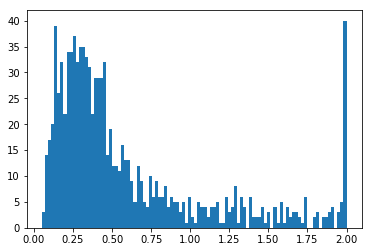

In [50]:
%pylab inline
plt.hist(lst,bins=100);
print np.mean(lst) 

In [51]:
i=1233
u=Y[i][:60]
v=a[i]
plt.plot(u)
plt.plot(v)
print np.median(u),np.median(v), (2*np.abs(u-v)/(np.abs(u)+np.abs(v))).mean()

3140.0 517.346 1.24003


In [52]:
daily_data.shape,attrib_data.shape

((145063, 550), (145063, 12))

In [53]:
daily_test=daily_data[:,-LEN1:]
attrib_test=attrib_data
daily_test.shape,attrib_test.shape

((145063, 128), (145063, 12))

In [54]:
feed_dict={x:daily_test,x2:attrib_test}
predTest=sess.run(prediction,feed_dict=feed_dict)
predTest.shape

(145063, 60)

In [55]:
predTest=np.round(predTest,1)
np.mean(predTest<1)

1.2982864916162862e-05

In [56]:
import datetime
cols=pd.date_range(pd.datetime.date(datetime.datetime(2017, 1, 1)), periods=60).map(lambda u: u.strftime("%Y-%m-%d"))
idx=pd.read_csv("../input/train_1.csv",usecols=[0])["Page"]
idx.shape

(145063,)

In [57]:
submission=pd.DataFrame(predTest,columns=cols,index=idx)
submission=submission.unstack().reset_index()
submission['name']=submission.apply(lambda r: r['Page']+"_"+r['level_0'],axis=1)
submission=submission.drop(['Page','level_0'],axis=1)
submission.columns=['Visits','name']

In [58]:
submission=submission[["name",'Visits']]
submission.head()

name     Visits
0  2NE1_zh.wikipedia.org_all-access_spider_2017-0...  19.299999
1  2PM_zh.wikipedia.org_all-access_spider_2017-01-01  21.200001
2   3C_zh.wikipedia.org_all-access_spider_2017-01-01   4.900000
3  4minute_zh.wikipedia.org_all-access_spider_201...  14.100000
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...  11.600000

In [59]:
keys=pd.read_csv("../input/key_1.csv",index_col=0)

In [60]:
keys_dict=keys["Id"].to_dict()

In [61]:
submission["Id"]=submission["name"].apply(lambda u:keys_dict[u])

In [62]:
submission.isnull().sum().sum()

0L

In [63]:
submission.head()

name     Visits            Id
0  2NE1_zh.wikipedia.org_all-access_spider_2017-0...  19.299999  ff8c1aade3de
1  2PM_zh.wikipedia.org_all-access_spider_2017-01-01  21.200001  3da6fd5b23c1
2   3C_zh.wikipedia.org_all-access_spider_2017-01-01   4.900000  cd9e83803be4
3  4minute_zh.wikipedia.org_all-access_spider_201...  14.100000  65cd4af0968c
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...  11.600000  75bae1fb2637

In [64]:
submission[["Id","Visits"]].to_csv("../submission/sub_pred_lstm1_60_512x3_nozero_xnopad.csv.gz",
                                   index=None, float_format='%.1f', compression="gzip")